Basic sequencing
================

In this tutorial we will demonstrate basic sequencer based operations (see section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html)). This includes creating a sequence, consisting of waveforms and a simple Q1ASM program,
and executing this sequence synchronously on multiple sequencers.

The sequence is going to consecutively play two waveforms, a gaussian and block with a duration of 20ns each, with an increasing wait period
in between them. We will increase the wait period 20ns a 100 times after which the sequence is stopped. The sequence will also trigger marker
output 1 at every interval, so that the sequence can be easily monitored on an oscilloscope.

This tutorial is designed with the Pulsar QCM in mind, but can easily be used with a Pulsar QRM as well. Change any Pulsar QCM reference to
Pulsar QRM and only use one sequencer.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from pulsar_qcm.pulsar_qcm import pulsar_qcm

#Close any existing connections to any pulsar_qcm
pulsar_qcm.close_all()

#Connect to the Pulsar QCM at default IP address.
pulsar = pulsar_qcm("qcm", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_status())

Status:
{'status': 'OKAY', 'flags': []}


Generate waveforms
------------------

Next, we need to create the gaussian and block waveforms for the sequence.

In [2]:
#Waveform parameters
waveform_length = 20 #nanoseconds
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": [], "index": 0},
                "block":    {"data": [], "index": 1}
            }

#Create gaussian waveform
if "gaussian" in waveforms:
    waveforms["gaussian"]["data"] = scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length)
        
#Create block waveform
if "block" in waveforms:
    waveforms["block"]["data"] = [1.0 for i in range(0, waveform_length)]

Let's plot the waveforms to see what we have created.

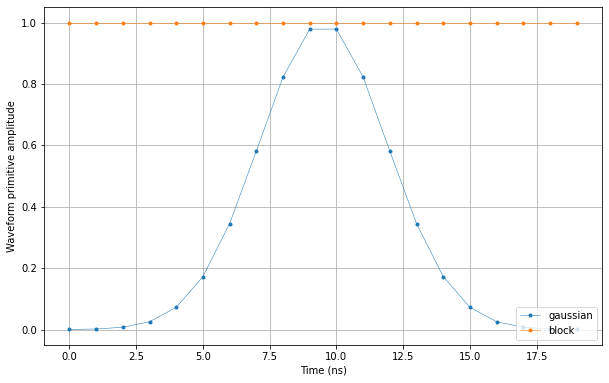

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()

matplotlib.pyplot.draw()
matplotlib.pyplot.show()   # add this at EOF to prevent execution stall

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described.

In [4]:
#Sequence program.
seq_prog = """
       move      100,R0   #Loop iterator.
       move      20,R1    #Initial wait period in ns.
       wait_sync 4        #Wait for sequencers to synchronize and then wait another 4ns.

loop:  set_mrk   1        #Set marker output 1.
       play      0,1,4    #Play a gaussian and a block on output path 0 and 1 respectively and wait 4ns.
       set_mrk   0        #Reset marker output 1.
       upd_param 16       #Update parameters and wait the remaining 16ns of the waveforms.

       wait      R1       #Wait period.

       play      1,0,20   #Play a block and a gaussian on output path 0 and 1 respectively.
       wait      1000     #Wait a 1us in between iterations.
       add       R1,20,R1 #Increase wait period by 20ns.
       loop      R0,@loop #Subtract one from loop iterator.

       stop               #Stop the sequence after the last iteration.
"""

Upload sequence
---------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [5]:
#Reformat waveforms to lists if necessary.
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()  # JSON only supports lists

#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": {}, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [6]:
#Upload waveforms and programs.
pulsar.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))
pulsar.sequencer1_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize.

In [7]:
#Configure the sequencers to synchronize.
pulsar.sequencer0_sync_en(True)
pulsar.sequencer1_sync_en(True)

#Map sequencers to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 4):
        pulsar.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar.sequencer0_channel_map_path0_out0_en(True)
pulsar.sequencer0_channel_map_path1_out1_en(True)
pulsar.sequencer1_channel_map_path0_out2_en(True)
pulsar.sequencer1_channel_map_path1_out3_en(True)

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on the marker output 1.

In [8]:
#Arm and start both sequencers.
pulsar.arm_sequencer(0)
pulsar.arm_sequencer(1)
pulsar.start_sequencer()

#Print status of both sequencers.
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))

Status:
{'status': 'STOPPED', 'flags': []}
{'status': 'STOPPED', 'flags': []}


Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [9]:
#Stop both sequencers.
pulsar.stop_sequencer()
    
#Print status of both sequencers (should now say it is stopped).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
{'status': 'STOPPED', 'flags': ['FORCED STOP']}
{'status': 'STOPPED', 'flags': ['FORCED STOP']}

Snapshot:
qcm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
out2_offset                                 :	0 (V)
out3_offset                                 :	0 (V)
reference_source                            :	internal 
sequencer0_channel_map_path0_out0_en        :	True 
sequencer0_channel_map_path0_out2_en        :	False 
sequencer0_channel_map_path1_out1_en        :	True 
sequencer0_channel_map_path1_out3_en        :	False 
sequencer0_cont_mode_en_awg_path0           :	False 
sequencer0_cont_mode_en_awg_path1           :	False 
sequencer0_cont_mode_waveform_idx_awg_path0 :	0 
sequencer0_cont_mode_waveform_idx_awg_p